# Research on Apartment Sale Listings

Here are the data from the Yandex Real Estate service — an archive of listings for apartments for sale in St. Petersburg and neighboring localities over several years. You need to learn to determine the market value of real estate properties. To do this, conduct an exploratory data analysis and identify the parameters that affect the price of the properties. This will allow you to build an automated system that can track anomalies and fraudulent activities.

For each apartment on sale, two types of data are available. The first type is entered by the user, and the second is automatically obtained based on mapping data. For example, distances to the city center, the airport, and other objects are automatically obtained from geoservices. The number of parks and bodies of water is also filled in without user participation.

## Analysis plan

There is a data set of the apartments advertisings on Yandex portal, which needs to be analysed. The following steps to be done 

1. Open and review metadata on dataset 
2. Clean the data (missing values, duplicates, outliers)
3. Create and analyize some metrics using histogram diagrams (consider outliers)
4. Analyze how fast the apartments were sold 
5. Find out correlation of several metrics to the apartment price 
6. Analyze the locations in regards to average sq. meter price, min and max sq. meter price.
7. Check how average apartment price is changing depending on the distance from the center 
8. Conclude the analysis

## Data Preparation

### Open dataset and analyze 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

data = pd.read_csv('real_estate_data.csv', sep='\t')
print(data.head(5))

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

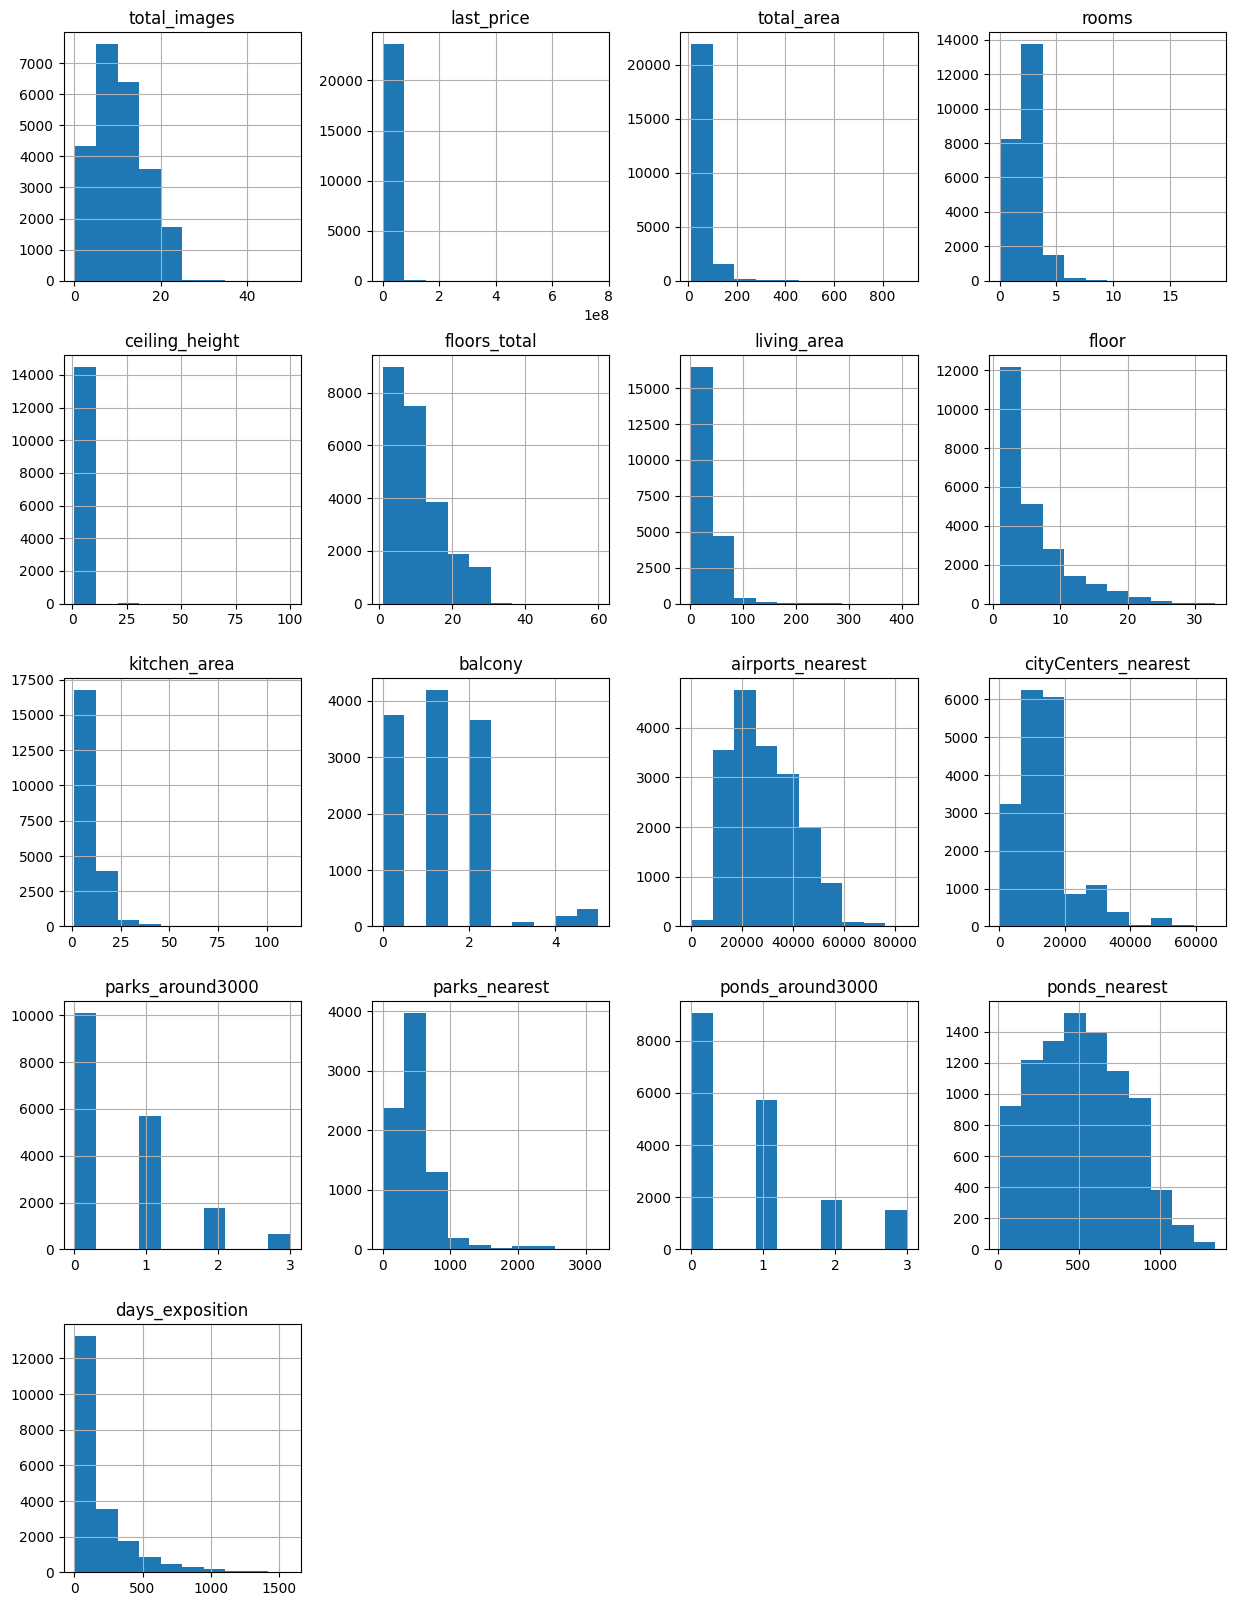

In [3]:
data.hist(figsize=(15, 20));

### Data Cleaning & Check of Duplicates

In [4]:
print(data.isnull().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


In [5]:
# Using correlaton between total and living area fill the missing values in the living area 

# Calculate the correlation between medians of living and total area
correlation_living = data['living_area'].median() / data['total_area'].median()

# fill the living area missing (NaN) data with total area value multiplied by correlation_living
data['living_area'] = data.apply(
    lambda row: row['total_area'] * correlation_living if pd.isna(row['living_area']) else row['living_area'], axis=1)

In [6]:
# Using correlaton between total and kitchen area fill the missing values in the kitchen area 

# Calculate the correlation between medians of kitchen and total area
correlation_kitchen = data['kitchen_area'].median() / data['total_area'].median()

# fill the kitchen area missing (NaN) data with total area value multiplied by correlation_kitchen
data['kitchen_area'] = data.apply(
    lambda row: row['total_area'] * correlation_kitchen if pd.isna(row['kitchen_area']) else row['kitchen_area'], axis=1)

In [7]:
# convert first_day_exposition column to the date-time format '%Y-%m-%dT%H:%M:%S'
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [8]:
#Analyze missing data in the days_exposition

data['days_missing'] = data['days_exposition'].isna()
missing_per_year = data.groupby(data['first_day_exposition'].dt.year)['days_missing'].sum()
print(missing_per_year)

first_day_exposition
2014      18
2015      70
2016      67
2017     271
2018     959
2019    1796
Name: days_missing, dtype: int64


Days_Exposition are missing for the latest years 2019-2018, maybe because the apartments are not yet sold, as they have been recently exposed for sale. 
Keep the data missing as it is. 

In [9]:
#delete rows in column floors_total with Nan, as there is are so many missing entries 
data.dropna(subset=['floors_total'], inplace=True)

In [10]:
#fill with 0.0 those columns with NaN values to maintain data in float type 
columns_array = ['balcony','cityCenters_nearest']
for column in columns_array:
      data[column] = data[column].fillna(0.0)

In [11]:
# convert data type of the column is_apartment to boolean 
data['is_apartment'] = data['is_apartment'].astype(bool)

In [12]:
# manage duplicates which are not obvious 
print(data['locality_name'].unique()) #find unique entries in the column 

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

In [13]:
#unify naming 
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['поселок'], 'посёлок', regex=True)
) 

In [14]:
#unify duplicate names 
data['locality_name'] = data['locality_name'].replace('посёлок городского типа Рябово', 'посёлок Рябово')
data['locality_name'] = data['locality_name'].replace('городской посёлок Рощино', 'посёлок городского типа Рощино')

### Add new columns to the dataset for further analysis

In [15]:
#one square meter price 
data['price_per_meter'] = (data['last_price'] / data['total_area']).round(2)

In [16]:
#day of the week the listing was published (0 — Monday, 1 — Tuesday, and so on)
data['post_weekday'] = data['first_day_exposition'].dt.weekday

In [17]:
#month the listing was published
data['post_month'] = pd.DatetimeIndex(data['first_day_exposition']).month

In [18]:
#year the listing was published
data['post_year'] = pd.DatetimeIndex(data['first_day_exposition']).year

In [19]:
#floor type of the apartment (values — "first", "top", "other")
#print(len(data['floor'].unique()))
def categorize_floor(floor):
    if floor == 1:
        return 'первый'
    if 1 < floor < 33:
        return 'другой'
    if floor == 33:
        return 'последний'
data['floor_type'] = data['floor'].apply(categorize_floor)
#print(data['floor_type'].value_counts())   

In [20]:
#distance to the city center in kilometers (convert from meters to kilometers and round to the nearest whole number)
data['to_city_center_km'] = (data['cityCenters_nearest'] / 1000).round()


In [21]:
print(data.head(10))

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00           2019-03-07      3   
1             7   3350000.0       40.40           2018-12-04      1   
2            10   5196000.0       56.00           2015-08-20      2   
3             0  64900000.0      159.00           2015-07-24      3   
4             2  10000000.0      100.00           2018-06-19      2   
5            10   2890000.0       30.40           2018-09-10      1   
6             6   3700000.0       37.30           2017-11-02      1   
7             5   7915000.0       71.60           2019-04-18      2   
8            20   2900000.0       33.16           2018-05-23      1   
9            18   5400000.0       61.00           2017-02-26      3   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70          16.0    51.000000      8          True  ...   
1             NaN          11.0    18.600000      1          True  ...

## EDA / Data analysis

### Histogram analysis

### Total area 

Data Shape : (23613, 29)
Number of rows : 23613
Number of columns : 29
% change after filter : 4.242450997704397


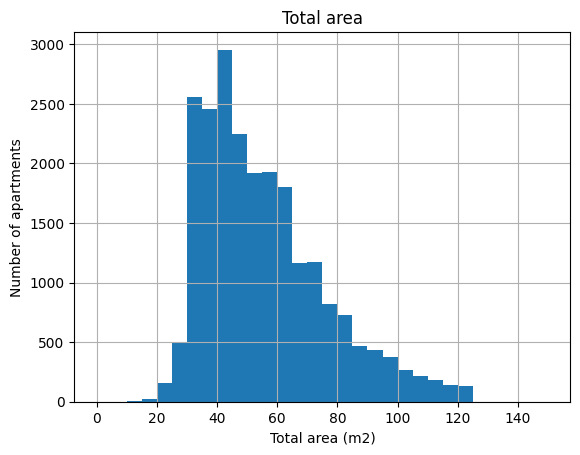

In [22]:
shape = data.shape 
print('Data Shape :', shape) 
print('Number of rows :', shape[0]) 
print('Number of columns :', shape[1])


filtered_total = data.query('total_area < 125')
print('% change after filter :',((data.shape[0] - 
filtered_total.shape[0]) / filtered_total.shape[0] *100))

filtered_total['total_area'].hist(bins = 30,  range = (0, 150))

plt.xlabel('Total area (m2)')
plt.ylabel('Number of apartments')
plt.title('Total area')
plt.show()

Total area is most often from 26 to 75 square meters, with a peak around 40 square meters.

### Living area 

% change after filter : 1.7450879007238882


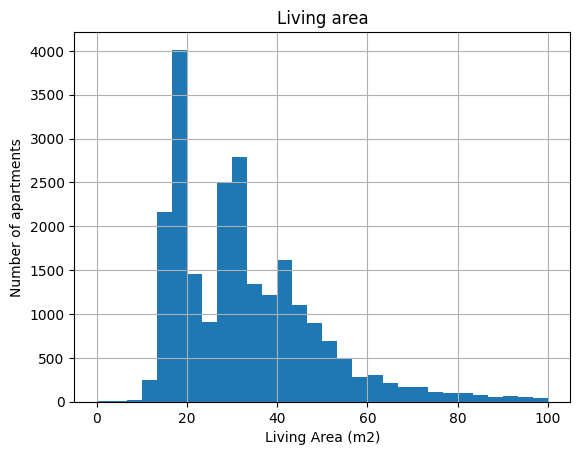

In [23]:

#data['living_area'].describe()
#print(data['living_area'].value_counts())

filtered_living = data.query('living_area != 0 and living_area < 100' )
print('% change after filter :',((data.shape[0] - 
filtered_living.shape[0]) / filtered_living.shape[0] *100))



filtered_living['living_area'].hist(bins = 30,range = (0, 100))
plt.xlabel('Living Area (m2)')
plt.ylabel('Number of apartments')
plt.title('Living area')
plt.show()

In this column, there were many 0 values, which were filtered out, and extremely large and rare values were also removed. Most often, the living area is from 18 square meters, and around 30 square meters.

### Kitchen area 

% change after filter : 1.8372363824556863


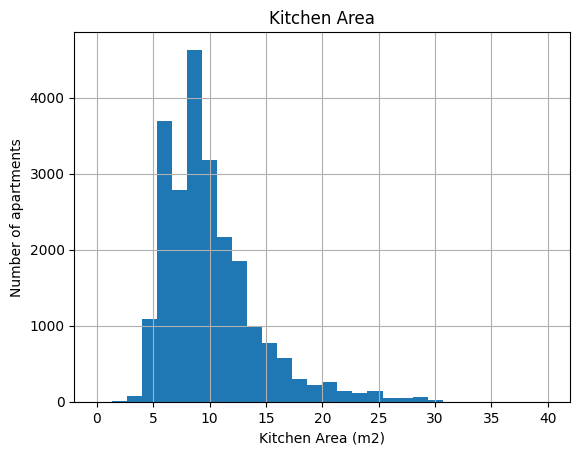

In [24]:

#data['kitchen_area'].unique()
#print(data['kitchen_area'].value_counts())
filtered_kitchen = data.query('kitchen_area != 0 and kitchen_area < 30' )
# claculate filtered % 
print('% change after filter :',((data.shape[0] - 
filtered_kitchen.shape[0]) / filtered_kitchen.shape[0] *100))

filtered_kitchen['kitchen_area'].hist(bins = 30,range = (0, 40))
plt.xlabel('Kitchen Area (m2)')
plt.ylabel('Number of apartments')
plt.title('Kitchen Area')
plt.show()

In this column, there were many 0 values, which were filtered out, and extremely large and rare values were also removed. Most often, the kitchen area is from 6 to 12 square meters, with a peak around 9 square meters.

### Price 

% change after filter : 7.591014717273431


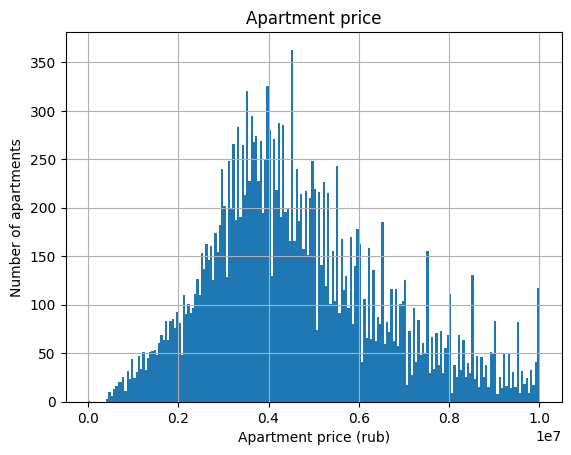

In [25]:
 
#data['last_price'].describe()
#print(data['last_price'].value_counts())
filtered_price = data.query('last_price < 13000000')

# claculate filtered % 
print('% change after filter :',((data.shape[0] - 
filtered_price.shape[0]) / filtered_price.shape[0] *100))

filtered_price['last_price'].hist(bins = 200, range = (0, 10000000))
plt.xlabel('Apartment price (rub)')
plt.ylabel('Number of apartments')
plt.title('Apartment price')
plt.show()
    

From the describe() function, it is evident that the average price is 6,541,549, which is 6 million, and the maximum value is 763,000,000, which is 763 million. The initial graph shows that such high values are very rare. Other statistics like quartiles also show a range of 3-7 million. Therefore, it makes sense to filter out extremely high values, for example, up to 10 million. On the graph, it becomes clearer that apartments most often cost between 2 and 6 million.



### Number of rooms 

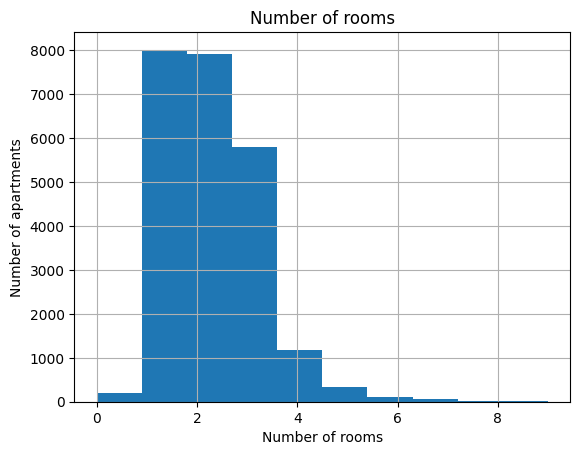

In [26]:
#data['rooms'].unique()
#data['rooms'].describe
#print(data['rooms'].value_counts())
data['rooms'].hist(bins = 10, range= (0,9))

plt.xlabel('Number of rooms')
plt.ylabel('Number of apartments')
plt.title('Number of rooms')
plt.show()

Most often, apartments have between 1 and 4 rooms

### Ceiling height 

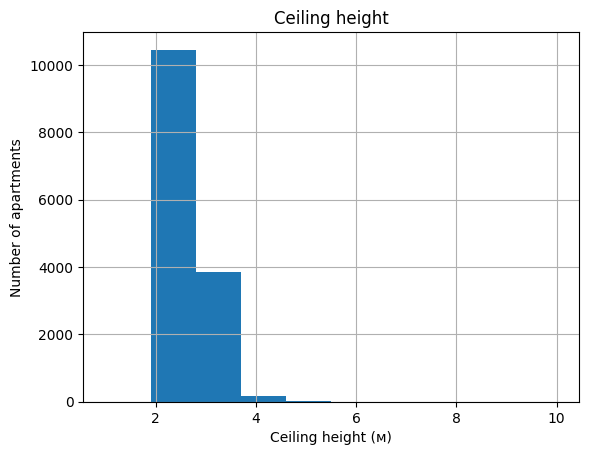

In [27]:
#data['ceiling_height'].unique()
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] *= 0.1 # при внесении данных возможно были опечатки, так как были слишком большие значения высоты потолка. После умножения на 0,1 выглядит более реалисточно 
data['ceiling_height'].hist(bins = 10, range= (1,10))
plt.xlabel('Ceiling height (м)')
plt.ylabel('Number of apartments')
plt.title('Ceiling height')
plt.show()

After processing the anomalous values, ceiling heights in apartments are most often between 2 and 4 meters.

### Floor Type (first, last, other)

floor_type
другой       20698
первый        2914
последний        1
Name: count, dtype: int64


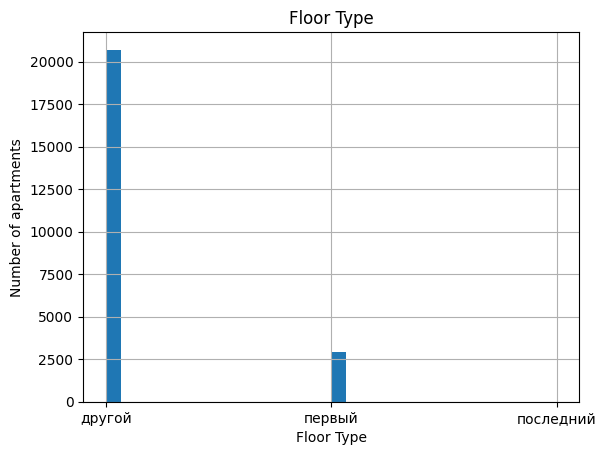

In [28]:

print(data['floor_type'].value_counts())
data['floor_type'].hist(bins = 30)
plt.xlabel('Floor Type')
plt.ylabel('Number of apartments')
plt.title('Floor Type')
plt.show()

There are very few top floors; most often, the floors are of other types.

### Number of floors 

% change after filter : 0.3356845415144047


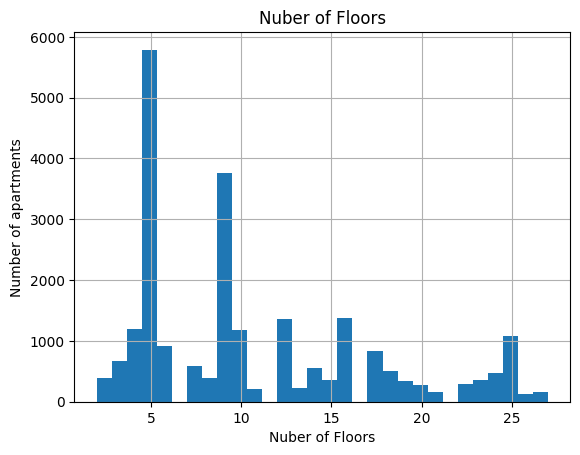

In [30]:

floors_count = data['floors_total'].value_counts() # посчитать кол-во уникальных значений 
filtered_floors = floors_count[floors_count > 100].index # отфильтровать те этажи, где меньше кол-во 100 
filtered_floor_data = data[data['floors_total'].isin(filtered_floors)] #отфильровать данные из табилицы 

# claculate filtered % 
print('% change after filter :',((data.shape[0] - 
filtered_floor_data.shape[0]) / filtered_floor_data.shape[0] *100))

filtered_floor_data['floors_total'].hist(bins = 30) # гистограмма 

plt.xlabel('Nuber of Floors')
plt.ylabel('Number of apartments')
plt.title('Nuber of Floors')
plt.show()

Most often, the floors range from 0 to 30, with the 5th floor being the most common.

### Distance to the city center in meters

% change after filter : 30.429739284136105


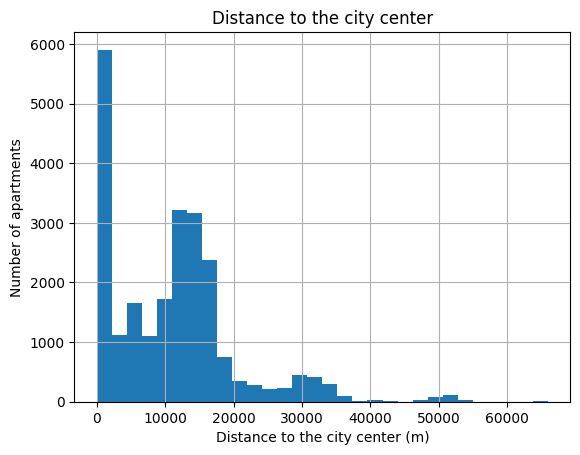

In [31]:

#print(data['cityCenters_nearest'].value_counts())
filtered_city = data.query('cityCenters_nearest != 0')

# claculate filtered % 
print('% change after filter :',((data.shape[0] - 
filtered_city.shape[0]) / filtered_city.shape[0] *100))

data['cityCenters_nearest'].hist(bins = 30)

plt.xlabel('Distance to the city center (m)')
plt.ylabel('Number of apartments')
plt.title('Distance to the city center')
plt.show()

The distance to the city center is often between 11 and 15 km. The percentage of discarded data is quite high at 30%, but the discarded values were mostly zeros.

### Distance to the nearest park

23613
% change after filter : 0.0


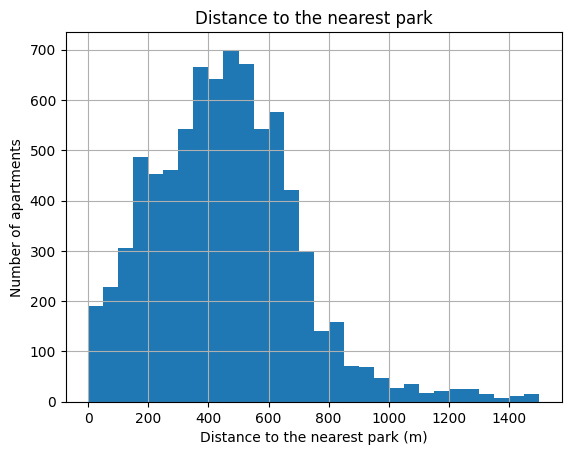

In [32]:

filtered_park = data.query('parks_nearest != 0' )
print(filtered_park.shape[0])
print('% change after filter :',((data.shape[0] - 
filtered_park.shape[0]) / filtered_park.shape[0] *100))


filtered_park['parks_nearest'].hist(bins = 30, range = (0,1500))

plt.xlabel('Distance to the nearest park (m)')
plt.ylabel('Number of apartments')
plt.title('Distance to the nearest park')
plt.show()

The distance to the park is on average between 200 and 700 meters. There were many missing data points, which were filtered out. After discarding the 0 values, there are only 8,054 data rows left out of the original 26,000.

##  Further Analysis of the dataset 

### Analyze how fast the apartments were sold 

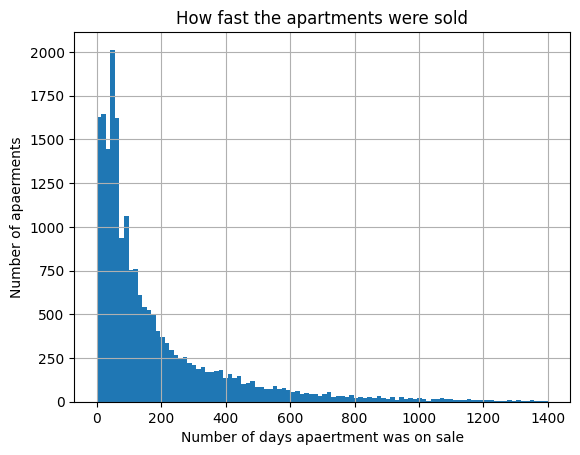

In [33]:

#data['days_exposition'].describe()
#print(data['days_exposition'].value_counts())

filtered_expo= data.query('days_exposition !=0')
#print(filtered_expo['days_exposition'].value_counts())
filtered_expo['days_exposition'].hist(bins = 100, range = (0,1400))

plt.xlabel('Number of days apaertment was on sale')
plt.ylabel('Number of apaerments')
plt.title('How fast the apartments were sold')
plt.show()


count    20441.000000
mean       180.884839
std        219.685543
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


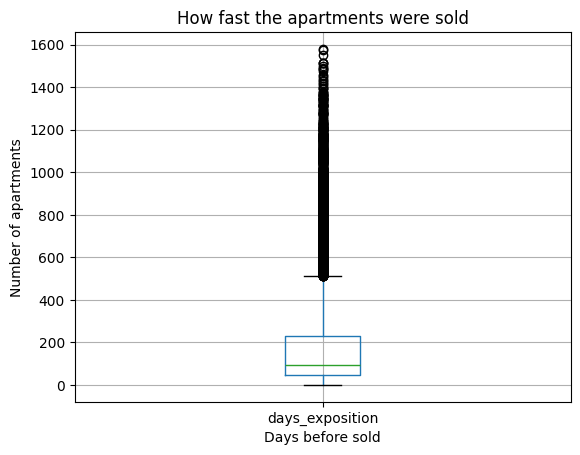

In [34]:
print(data['days_exposition'].describe())
#create boxplot diagram for 'days_exposition' column 
data.boxplot(column=['days_exposition'])

plt.title('How fast the apartments were sold')
plt.xlabel('Days before sold')
plt.ylabel('Number of apartments')
plt.show()


# Не работает matplotlib.pyplot - вопрос в комментарии ниже 
# plt.boxplot(data['days_exposition'])

For this analysis it is better use boxplot diagram to see summery on several metrics, additionally describe() method can support here for more deatiled information. 

Here we can see outlieres which are beyond whiskers - more than 232 days, what we can consider as apartments which takes longer time to be sold. 

Q1 (45 day) and what is below can be considerered the fast selling apartments. 

### Correlation of the price and total area (Correleation & Scatter Matrix)

0.6535810085611219
0.7174447899214247


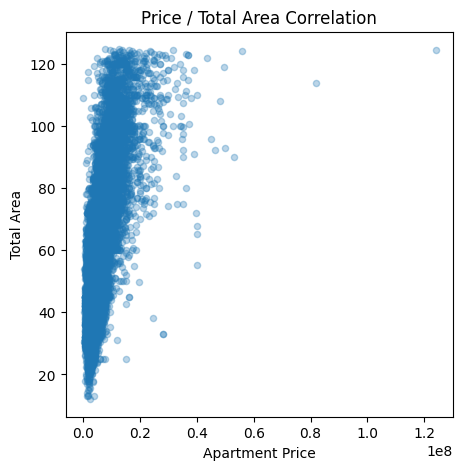

In [35]:

#Pearson correlation coefficient

print(data['last_price'].corr(data['total_area'])) 
print(filtered_price['last_price'].corr(filtered_total['total_area'])) #Pearson correlation coefficient filtered

#correlation graph
filtered_total.plot(x='last_price', y='total_area', kind='scatter', alpha=0.3, figsize=(5,5))
plt.xlabel('Apartment Price')
plt.ylabel('Total Area')
plt.title('Price / Total Area Correlation')
plt.show()

There is a relationship between living area and price on the graph for apartments priced up to 3-4 million. As the area increases, the price slightly increases as well. The Pearson coefficient of 0.66 indicates a moderate correlation.

### Correlation of the price and living area

0.5857750569439147
0.6061243199192299


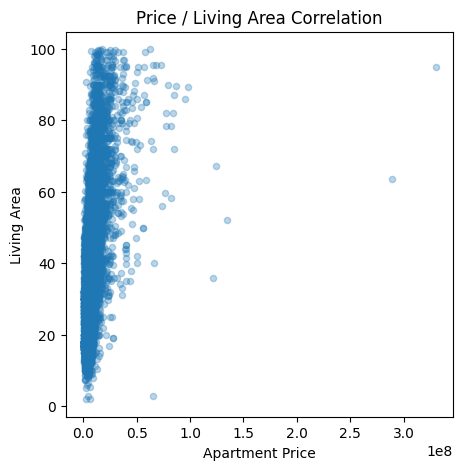

In [36]:

#Pearson correlation coefficient
print(data['last_price'].corr(data['living_area'])) 
print(filtered_price['last_price'].corr(filtered_living['living_area'])) 


#correlation graph
filtered_living.plot(x='last_price', y='living_area', kind='scatter', alpha=0.3, figsize=(5,5))

plt.xlabel('Apartment Price')
plt.ylabel('Living Area')
plt.title('Price / Living Area Correlation')
plt.show()


A slight dependence of living area on price is visible on the graph for apartments priced up to 4 million. As the area increases, the price increases slightly as well. The Pearson coefficient of 0.54 indicates a moderate correlation.

### Correlation of the price and kitchen area

0.5141906651095525
0.612143648830373


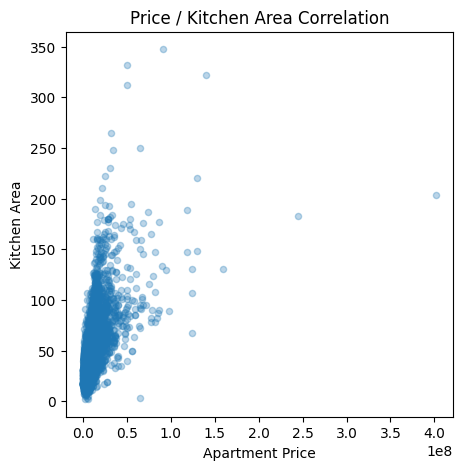

In [37]:

print(data['last_price'].corr(data['kitchen_area'])) #Pearson correlation coefficient
print(filtered_price['last_price'].corr(filtered_kitchen['living_area'])) #Pearson correlation coefficient filtered
# correlation matrix 

filtered_kitchen.plot(x='last_price', y='living_area', kind='scatter', alpha=0.3, figsize=(5,5))

plt.xlabel('Apartment Price')
plt.ylabel('Kitchen Area')
plt.title('Price / Kitchen Area Correlation')
plt.show()


A slight dependence of kitchen area on price is visible on the graph for apartments priced up to 4 million. As the area increases, the price increases slightly as well. The Pearson coefficient of 0.51 indicates a moderate correlation.

### Correlation of the price and number of rooms

0.3631241665984551


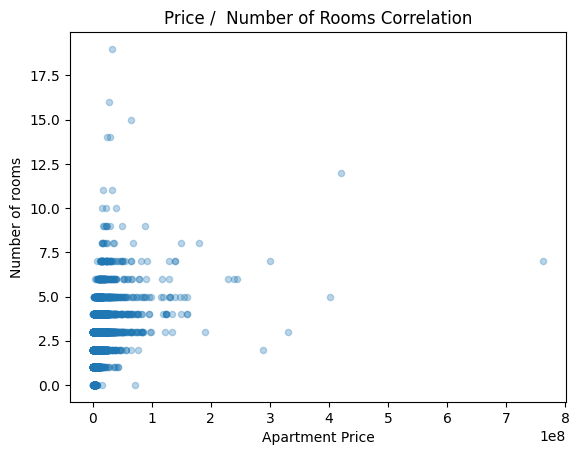

In [38]:

print(data['last_price'].corr(data['rooms'])) #Pearson correlation coefficient
data.plot(x='last_price', y='rooms', kind='scatter', alpha=0.3)
plt.xlabel('Apartment Price')
plt.ylabel('Number of rooms')
plt.title('Price /  Number of Rooms Correlation')
plt.show()


The dependence of the number of rooms on price is very weak, with a Pearson coefficient of 0.36.

### Correlation of the price and floor type 

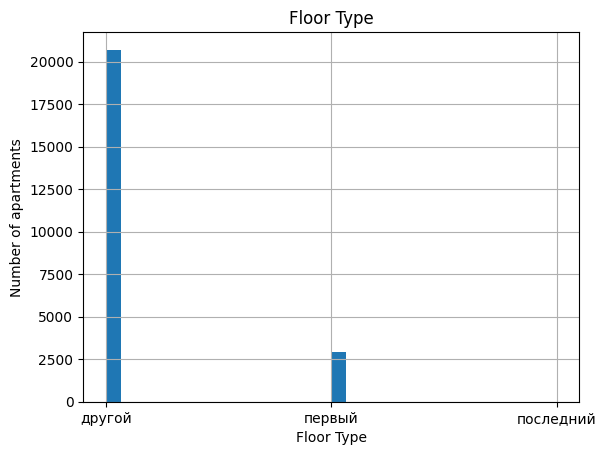

In [39]:


data['floor_type'].hist(bins = 30)
plt.xlabel('Floor Type')
plt.ylabel('Number of apartments')
plt.title('Floor Type')
plt.show()


(v2 Comment)
It is better to use bar chart to see the correlation, as it is no linear.  
The most of the apartments are in 'Other' type of floor. 

### Correlation of the price and weekday 

0.0012947242289498427


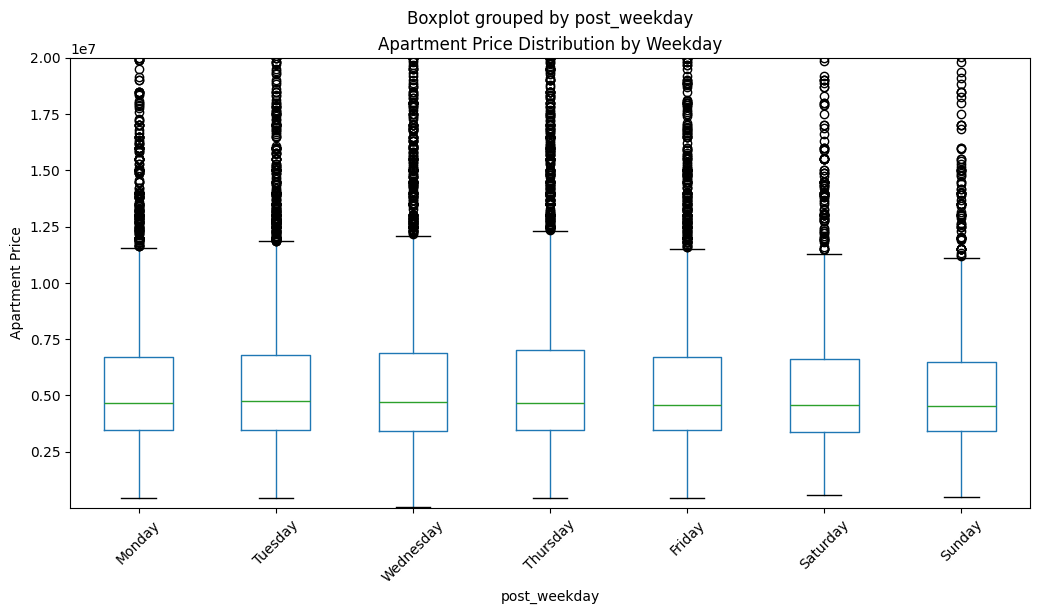

In [40]:
#Pearson correlation coefficient
print(data['last_price'].corr(data['post_weekday'])) 

#create boxplot for price / year correltion 
bp = data.boxplot(column='last_price', by='post_weekday', figsize=(12, 6), grid=False)

bp.set_title('Apartment Price Distribution by Weekday')
bp.set_ylim (1,20000000)
bp.set_ylabel('Apartment Price')
bp.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.show()

On this boxplot we can observe no dependency on price and weekday when apartment was published. 

0.00276523265748841


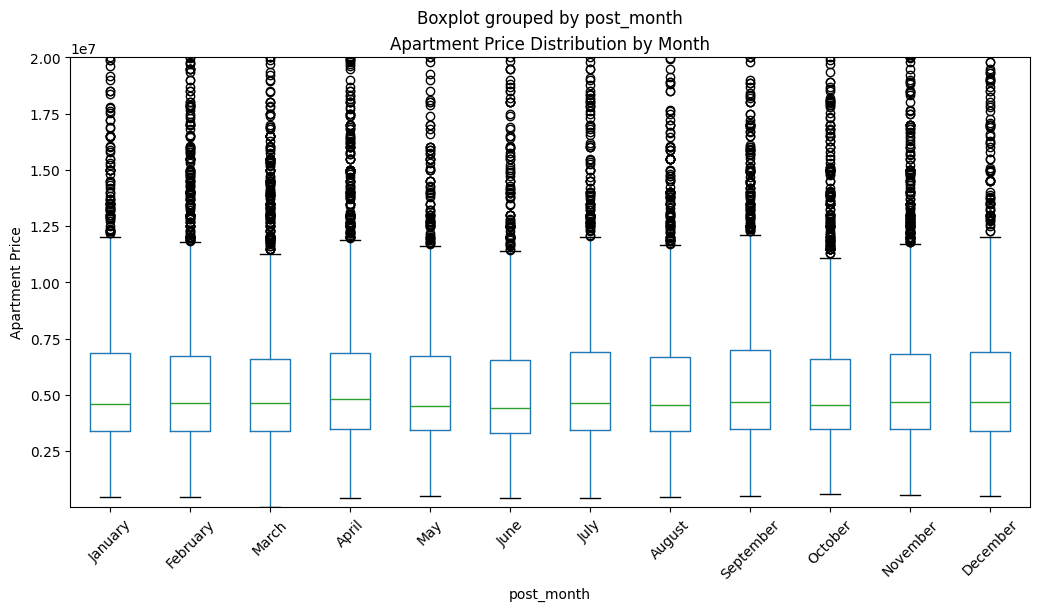

In [41]:
#Pearson correlation coefficient
print(data['last_price'].corr(data['post_month'])) 

#create boxplot for price / year correltion 
bp = data.boxplot(column='last_price', by='post_month', figsize=(12, 6), grid=False)
bp.set_title('Apartment Price Distribution by Month')
bp.set_ylim (1,20000000)
bp.set_ylabel('Apartment Price')
bp.set_xticklabels(["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"], rotation=45)
plt.show()

There is no big difference in the prices of the apartment depending on the month it has been posted. Just a slight decrease of price in May, June, August and October. 

-0.04302312009925644


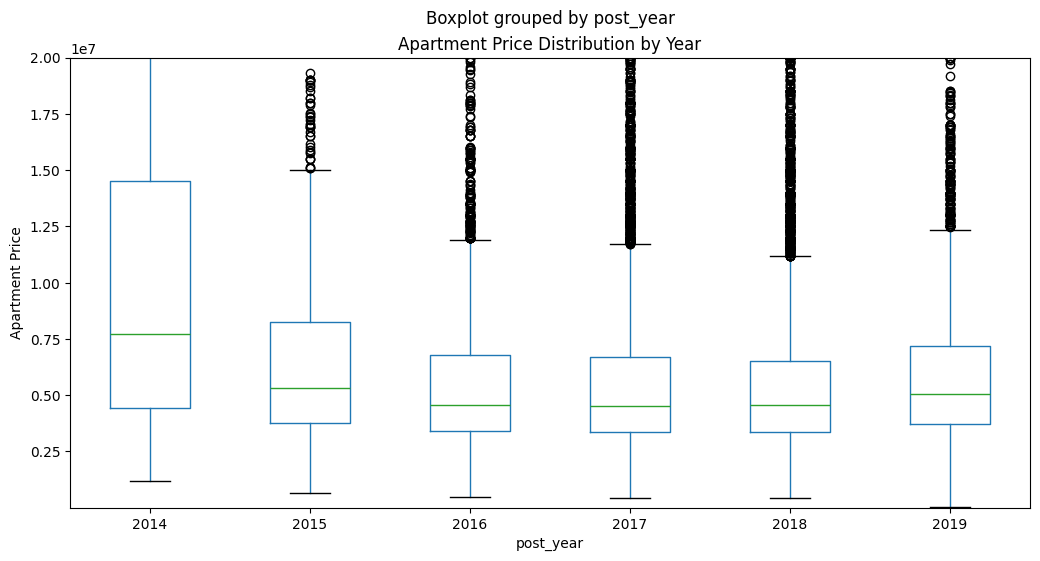

In [42]:
#Pearson correlation coefficient
print(data['last_price'].corr(data['post_year'])) 

#create boxplot for price / year correltion 
bp = data.boxplot(column='last_price', by='post_year', figsize=(12, 6), grid=False)
bp.set_title('Apartment Price Distribution by Year')
bp.set_ylim (1,20000000)
bp.set_ylabel('Apartment Price')
plt.show()

In this boxplot graphic we can see that in 2014 the average apartment price was higher than in the following years. In 2015 and and 2019 little bit higher than in 2016-2018. 

##  Additional Statistics 

### Calculate the average price per square meter in the 10 localities with the highest number of listings.

In [43]:

data['sqm_price'] = data['last_price'] / data['total_area']
stat_avg = data.pivot_table(index = 'locality_name', values='sqm_price', aggfunc=['mean', 'count'])
print(stat_avg.sort_values(by = ('count', 'sqm_price'), ascending = False).head(10))
# min square price 
stat_min = data.pivot_table(index = 'locality_name', values='sqm_price', aggfunc=['min'])
print(stat_min.sort_values(by = ('min', 'sqm_price'), ascending = True).head(3))
# max square price 
stat_max = data.pivot_table(index = 'locality_name', values='sqm_price', aggfunc=['max'])
print(stat_max.sort_values(by = ('max', 'sqm_price'), ascending = False).head(3))

                            mean     count
                       sqm_price sqm_price
locality_name                             
Санкт-Петербург    114868.877341     15651
посёлок Мурино      85629.568678       552
посёлок Шушары      78551.344545       439
Всеволожск          68654.473986       398
Пушкин             103125.819291       369
Колпино             75424.579098       338
посёлок Парголово   90175.913458       327
Гатчина             68746.146763       307
деревня Кудрово     92473.547576       299
Выборг              58141.909153       237
                               min
                         sqm_price
locality_name                     
Санкт-Петербург         111.834862
посёлок станции Свирь  7962.962963
Сланцы                 9615.384615
                          max
                    sqm_price
locality_name                
Санкт-Петербург  1.907500e+06
Всеволожск       6.404224e+05
Зеленогорск      3.239437e+05


The first summary table shows the average price per square meter in the localities with the highest number of listings. The minimum price per square meter is 111 rubles in St. Petersburg, and the highest price, 1,907,500 rubles, is also in St. Petersburg. This can be explained by the diversity of housing on the city's market.

### Average apartment price per km from center 

                     last_price
to_city_center_km              
0.0                3.280378e+06
1.0                2.115871e+07
2.0                1.780829e+07
3.0                1.111332e+07
4.0                1.327061e+07
...                         ...
61.0               3.200000e+06
62.0               3.200000e+06
63.0               3.600000e+06
65.0               3.475000e+06
66.0               3.933333e+06

[61 rows x 1 columns]
-0.050945702736070936


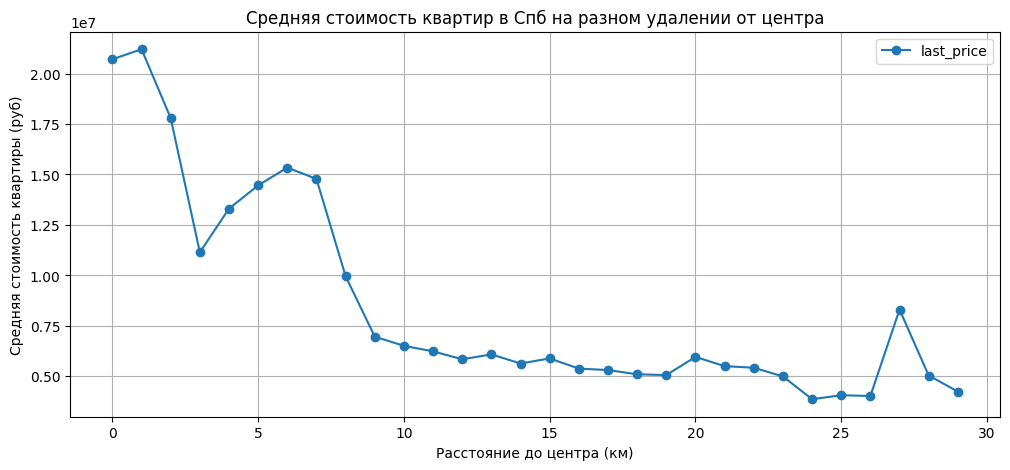

In [44]:
price_km = data.pivot_table(index='to_city_center_km', values='last_price', aggfunc='mean')
print(price_km)
print(data['last_price'].corr(data['to_city_center_km']))
(
    data.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='to_city_center_km', values='last_price', aggfunc='mean')
     .plot(grid=True, figsize=(12, 5), marker='o')
)
plt.xlabel('Расстояние до центра (км)')
plt.ylabel('Средняя стоимость квартиры (руб)')
plt.title('Средняя стоимость квартир в Спб на разном удалении от центра')
plt.show()

The graph shows that prices are not always stable, but there is a general trend of decreasing prices with increasing distance from the city. However, there are occasional contradictory peaks (between 4-6 km, around 9-12 km, and 26-28 km) where prices rise again, which may be related to other factors such as housing quality, area, year of construction, etc.

## Conclusion


Conclusion for the data set on propety in Saint Petersbug and Leningrad Region. 
The most apartments in the data set have total area of 26-60 sq.meters. In most cases living area is around 18 sq.meters, and the kitchen area is around 8 sq. meters. 
In regards to price, many of the apartments cost in the range from 3 to 7 million rubles having 1-3 rooms with celiling height 2-3 meter. Also most of the properties are not located on first or the last floor. And most of the houses are 5 floor buildings. 
Additionally, most of the apartments are located 10-15 km from the city center and 200-700 meters to the nearest parks. 
Usually the apartments are sold in the first 50 days. 

Regarding the dependencies we can observe here the followoing correlation of apartments price and the following factors. For total area, living area and kitchen area there is average positive correlation, which shows the increase of the price with the increase of the area. Other factors like number of rooms, floor type, or date of advertising posting (week day, month, year) show week correlation, meaning that they do not have much influence on the final price of the property. 

The average price per sq. meters with the most active locations is found in Saint Petersburg and Pushking, followed by village Pargolovo and village Kudrovo, Murino and Shushary. 
However the lowest sq. meter price and the hight have been identified again in Saint Petersburg. What lead us to the conclusion that this could be for the reason that the city is big and diverse in terms of properties.  

As well we can observe that the average apartment price is growing by the increase of the disctance from the city center. There are some deviations, which can be influnced by other factors like quality of the property, total living area, infrastructure around. Anyhow, the dependency between average apartment price and distance from the apartement can be identified. 